In [3]:
import seaborn as sns
from matplotlib import rc
from pylab import rcParams

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

NOTEBOOK = 'COLAB'

In [12]:
path_to_training = '../data/root/testing.csv'
path_to_testing  = '../data/root/training.csv'

In [13]:
import pandas as pd

df = pd.concat([
    pd.read_csv(path_to_training),
    pd.read_csv(path_to_testing)
]
)

df.head()

,text,1-RAPPORT,2-NEGOTIATE,3-EMOTION,4-LOGIC,5-AUTHORITY,6-SOCIAL,7-PRESSURE,8-NO-PERSUASION
0,How are you?,1,0,0,0,0,0,0,0
1,Hello.\nHow are you?,1,0,0,0,0,0,0,0
2,organizing,0,0,0,0,0,0,0,1
3,That's great!,1,0,0,0,0,0,0,0
4,e,0,0,0,0,0,0,0,1


In [14]:
# df['not_persuasion'] = [1 if i == 0 else 0 for i in df['is_persuasion'].tolist()]

In [15]:
df.sum()

text               How are you?Hello.\nHow are you?organizingThat...
1-RAPPORT                                                       4312
2-NEGOTIATE                                                     1688
3-EMOTION                                                       1169
4-LOGIC                                                          376
5-AUTHORITY                                                      412
6-SOCIAL                                                          21
7-PRESSURE                                                         5
8-NO-PERSUASION                                                  743
dtype: object

In [16]:
from sklearn.model_selection import train_test_split

train_df, eval_df = train_test_split(df, test_size=0.2)
print(f'Num Training {len(train_df)}')
print(f'Num Evaluation {len(eval_df)}')

Num Training 6917
Num Evaluation 1730


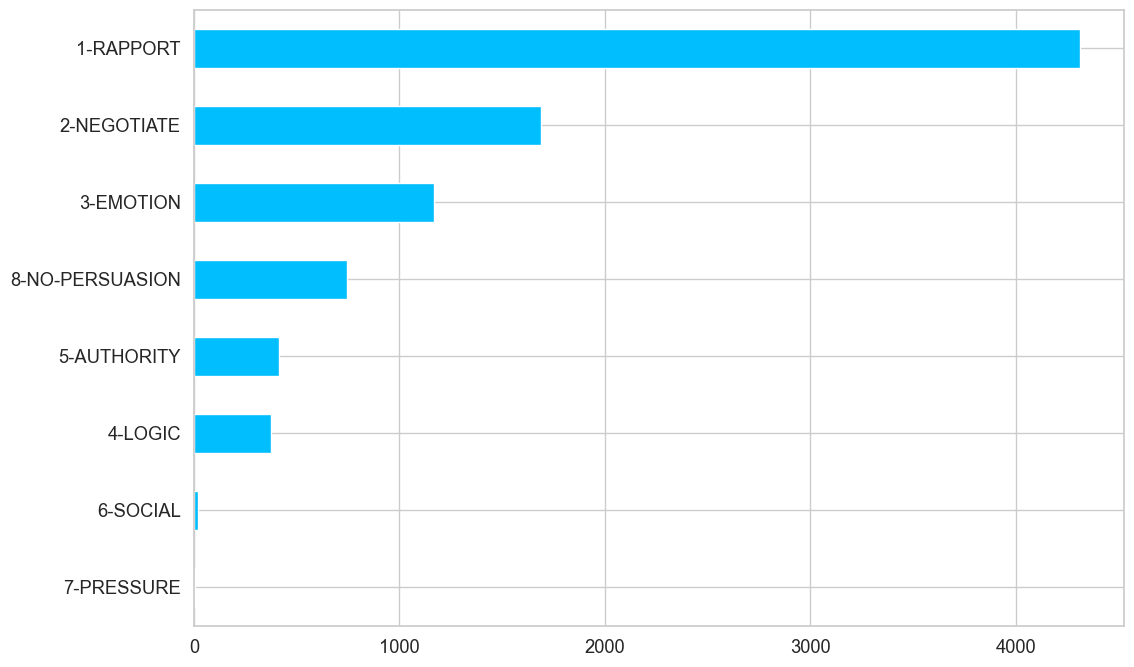

In [17]:
import matplotlib.pyplot as plt

LABEL_COLUMNS = df.columns.tolist()[1:]
df[LABEL_COLUMNS].sum().sort_values().plot(kind="barh");

In [18]:
from transformers import BertTokenizer, BertModel, RobertaModel, AutoTokenizer

BERT_MODEL_NAME = 'chkla/roberta-argument'
tokenizer = AutoTokenizer.from_pretrained(BERT_MODEL_NAME)

tokenizer_config.json:   0%|          | 0.00/255 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/790 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

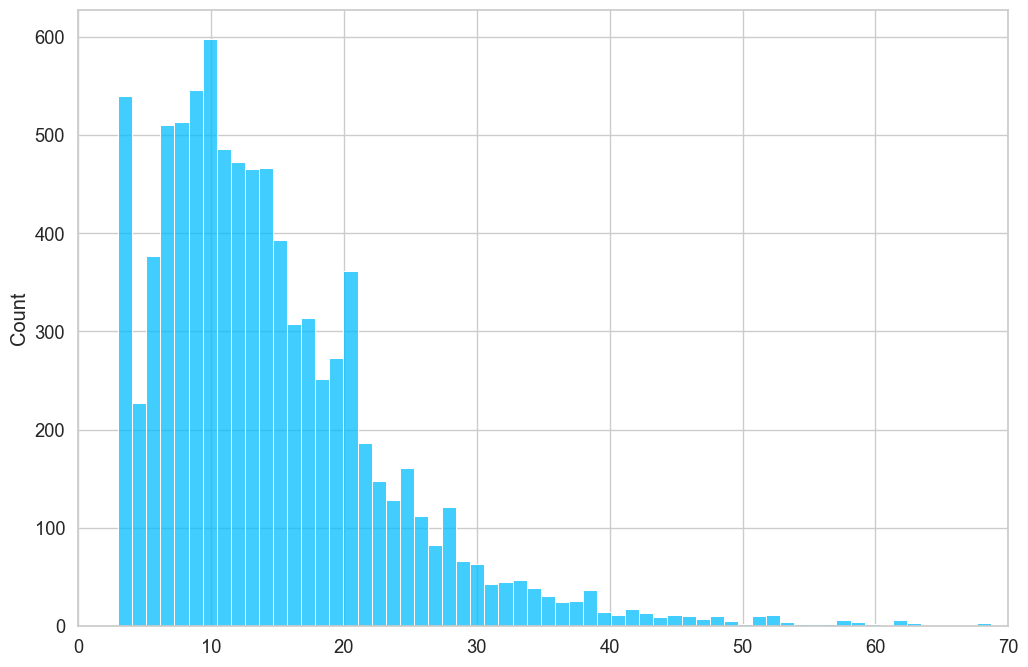

In [19]:
def visualise_tokencounts(df, column_name, max_tokens):

    token_counts = []

    for _, row in df.iterrows():

        token_count = len(tokenizer.encode(
        row[column_name],
        max_length=max_tokens+50,
        truncation=True

      ))

        token_counts.append(token_count)
    sns.histplot(token_counts)
    plt.xlim([0, max_tokens]);

visualise_tokencounts(df, 'text', 70)

In [20]:
MAX_TOKEN_COUNT = 70

In [48]:
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torch
BERT_MODEL_NAME = 'chkla/roberta-argument'
LABEL_COLUMNS =[
    # 'is_persuasion', 'not_persuasion']
  '1-RAPPORT',
                '2-NEGOTIATE',
                '3-EMOTION',
                '4-LOGIC',
                '5-AUTHORITY',
                '6-SOCIAL',
                '7-PRESSURE',
                '8-NO-PERSUASION']

class PersuasionStrategyDataset(Dataset):

    def __init__(

        self,

        data: pd.DataFrame,
        tokenizer: BertTokenizer,
        max_token_len: int = 64

        ):

        self.tokenizer = tokenizer
        self.data = data
        self.max_token_len = max_token_len
        self.LABEL_COLUMNS = data.columns.tolist()[1:]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index: int):

        data_row = self.data.iloc[index]
        comment_text = data_row.text
        labels = data_row[self.LABEL_COLUMNS]
        encoding = self.tokenizer.encode_plus(

          comment_text,
          add_special_tokens=True,
          max_length=self.max_token_len,
          return_token_type_ids=False,
          padding="max_length",
          truncation=True,
          return_attention_mask=True,
          return_tensors='pt',
        )

        return dict(
          comment_text=comment_text,
          input_ids=encoding["input_ids"].flatten(),
          attention_mask=encoding["attention_mask"].flatten(),
          labels=torch.FloatTensor(labels)

        )

In [49]:
from collections import Counter

In [68]:
training_dataset = PersuasionStrategyDataset(
    train_df,
    tokenizer
)

import warnings

# Ignore specific warning types
warnings.filterwarnings("ignore", category=FutureWarning)

In [70]:
labels = [torch.argmax(label['labels']).item() for label in training_dataset]  # Assuming your dataset returns (input_vector, label) pairs
class_distribution = Counter(labels)
print("Class distribution before balancing:", class_distribution)

Class distribution before balancing: Counter({0: 3502, 1: 1356, 2: 927, 7: 500, 4: 329, 3: 290, 5: 11, 6: 2})


In [72]:
# Calculate weights for each sample
class_weights = {class_label: len(training_dataset) / (len(class_distribution) * class_count) for class_label, class_count in class_distribution.items()}
weights = [class_weights[label] for label in labels]
print(class_weights)

{0: 0.2468946316390634, 4: 2.6280395136778116, 2: 0.9327130528586839, 1: 0.6376290560471977, 7: 1.72925, 3: 2.981465517241379, 6: 432.3125, 5: 78.60227272727273}


In [75]:

# Convert weights to tensor
weights_tensor = torch.tensor(weights, dtype=torch.float)

# print(weights_tensor)
# Create a sampler to balance the dataset during training
sampler = WeightedRandomSampler(weights_tensor, len(weights_tensor))

In [92]:

training_dataloader = DataLoader(
    training_dataset,
    batch_size=32,
    sampler=sampler
)

In [95]:
import torch.nn as nn
from transformers import RobertaModel

# Load pre-trained BERT model and tokenizer
bert_model = RobertaModel.from_pretrained('chkla/roberta-argument')
tokenizer = AutoTokenizer.from_pretrained('chkla/roberta-argument')

# Define your classification model
class BertClassifier(nn.Module):
    def __init__(self, bert_model, num_labels):
        super(BertClassifier, self).__init__()
        self.bert = bert_model
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        return logits

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at chkla/roberta-argument and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [96]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [97]:
model = BertClassifier(bert_model, len(LABEL_COLUMNS))

In [98]:
model.to(device)

BertClassifier(
  (bert): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNo

In [99]:
# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()  # Binary cross-entropy loss for multilabel classification
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)

In [100]:
from tqdm.auto import tqdm

In [101]:
num_epochs = 3

In [102]:

for epoch in tqdm(range(num_epochs), total=num_epochs):
    model.train()
    epoch_loss = 0
    for batch_num, batch in tqdm(
        enumerate(training_dataloader),
        total=len(training_dataloader)
    ):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()

        outputs = model(input_ids, attention_mask)

        loss = criterion(outputs, labels.float())  # Convert labels to float for BCELoss
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/217 [00:00<?, ?it/s]

  0%|          | 0/217 [00:00<?, ?it/s]

  0%|          | 0/217 [00:00<?, ?it/s]

In [103]:
model.to(device)

BertClassifier(
  (bert): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNo

In [104]:
val_dataset = PersuasionStrategyDataset(
    eval_df,
    tokenizer
)

val_loader = DataLoader(
    val_dataset,
    batch_size=32
)

In [105]:
# Evaluation loop
# Assuming val_loader contains your validation data in batches

true_labels = []
predicted_labels = []

model.eval()
with torch.no_grad():
    for batch in tqdm(val_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask)
        predicted_probs = torch.sigmoid(outputs)

        # Convert probabilities to binary predictions
        predicted_labels.extend(predicted_probs.cpu().numpy() > 0.5)
        true_labels.extend(labels.cpu().numpy())


  0%|          | 0/55 [00:00<?, ?it/s]

In [ ]:
# Assuming your trained model is named 'model' and you want to save it to a file named 'model.pth'
torch.save(model.state_dict(), './multilabel_bert_large_model.pth')


In [106]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import classification_report

# Calculate evaluation metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='micro')
recall = recall_score(true_labels, predicted_labels, average='micro')
f1 = f1_score(true_labels, predicted_labels, average='micro')
report = classification_report(
    true_labels, predicted_labels,target_names=LABEL_COLUMNS,
    )  # label_names is a list of class names
# Create or open a text file for writing
with open("evaluation_metrics.txt", "w") as file:
    # Write evaluation metrics to the file
    file.write("Accuracy: " + str(accuracy) + "\n")
    file.write("Precision: " + str(precision) + "\n")
    file.write("Recall: " + str(recall) + "\n")
    file.write("F1 Score: " + str(f1) + "\n")
    file.write("Confusion Matrix:\n" + str(report) + "\n")
    file.write("Epochs: " + str(num_epochs) + "\n")

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [107]:
print(report)

                 precision    recall  f1-score   support

      1-RAPPORT       0.95      0.80      0.87       901
    2-NEGOTIATE       0.83      0.82      0.82       317
      3-EMOTION       0.78      0.79      0.78       215
        4-LOGIC       0.39      0.58      0.47        86
    5-AUTHORITY       0.67      0.84      0.74        79
       6-SOCIAL       0.00      0.00      0.00         1
     7-PRESSURE       0.00      0.00      0.00         1
8-NO-PERSUASION       0.65      0.79      0.71       136

      micro avg       0.82      0.79      0.80      1736
      macro avg       0.53      0.58      0.55      1736
   weighted avg       0.84      0.79      0.81      1736
    samples avg       0.79      0.79      0.79      1736
